# Koncept drift analýza v metabolomické predikci při chladových stresových podmínkách u rostlin

Tento modul implementuje kompletní pipeline pro analýzu metabolitů
s detekcí koncept driftu pomocí metod DDM a EDDM a korekcí koncept použitím různých metod škálování a retrénování modelu.

Autor: Tereza Lusková
Datum: 2025

## Instalace a import knihoven

In [83]:
!pip install scikit-learn
!pip install numpy scipy scikit-learn
!pip install scikit-multiflow


In [84]:
# Zpracování dat
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from scipy.stats import pearsonr
from sklearn.pipeline import make_pipeline
from matplotlib.lines import Line2D

# Validace, trénování a testování modelu
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Modely
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Detekce a korekce koncept driftu
from skmultiflow.drift_detection import DDM, EDDM

# Metriky
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Načtení dat

Použité datasety jsou ze studie Weiszmann a spol.

WEISZMANN, Jakob; WALTHER, Dirk; CLAUW, Pieter; BACK, Georg; GUNIS, Joanna; REICHARDT, Ilka; KOEMEDA, Stefanie; JEZ, Jakub; NORDBORG, Magnus; SCHWARZEROVA, Jana; PIERIDES, Iro; NÄGELE, Thomas; WECKWERTH, Wolfram. Metabolome plasticity in 241 Arabidopsis thaliana accessions reveals evolutionary cold adaptation processes. Plant Physiology. 2023, roč. 193, č. 2, s. 980–1000. Dostupné z doi: 10.1093/plphys/kiad298

In [85]:
# Načtení dat
# Soubor s koncentracemi metabolitů měřenými při 6 °C podle studie Weiszmann et al.
file_6_degree_c = "Metabolites_Ath_6C.xlsx"

# Soubor s koncentracemi metabolitů měřenými při 16 °C podle studie Weiszmann et al.
file_16_degree_c = "Metabolites_Ath_16C.xlsx"

# Soubor s daty relativní růstové rychlosti (relative growth rate – RGR) měřenými při 6 °C podle studie Weiszmann et al.
file_6_degree_rgr = "Phenotype_Ath_RGR_6.xlsx"

# Soubor s daty relativní růstové rychlosti (relative growth rate – RGR) měřenými při 16 °C podle studie Weiszmann et al.
file_16_degree_rgr = "Phenotype_Ath_RGR_16.xlsx"


In [86]:
# Načtení dat koncentrací metabolitů při 6 °C (bez hlavičky sloupců)
data_6_degree_c = pd.read_excel(file_6_degree_c, header=None)

# Načtení dat koncentrací metabolitů při 16 °C (bez hlavičky sloupců)
data_16_degree_c = pd.read_excel(file_16_degree_c, header=None)

# Načtení dat relativní růstové rychlosti (RGR) při 6 °C (bez hlavičky sloupců)
output_data_6_degree_rgr = pd.read_excel(file_6_degree_rgr, header=None)

# Načtení dat relativní růstové rychlosti (RGR) při 16 °C (bez hlavičky sloupců)
output_data_16_degree_rgr = pd.read_excel(file_16_degree_rgr, header=None)

## Rozdělení dat

In [87]:
# Vytvoření kopií původních dat pro bezpečnou práci bez ovlivnění originálu
original_data_6_degree_c = data_6_degree_c.copy()
original_data_16_degree_c = data_16_degree_c.copy()

# Extrakce názvů ekotypů (prvního sloupce kromě hlavičky)
names_of_ecotypes = original_data_6_degree_c.iloc[1:, 0].astype(str).apply(lambda x: x.split(',')[0]).tolist()

# Extrakce názvů metabolitů z hlavičky (první řádek, první položka je pravděpodobně ID nebo název)
names_of_metabolites = original_data_6_degree_c.iloc[0, 0].split(',')[1:]

# Definice množiny cukrů pro pozdější filtrování
sugars = {'Maltose', 'Fructose', 'Galactose', 'Glucose'}

def extract_data(data, col=0):
    """
    Extrahuje číselná data z CSV formátovaného řetězce ve sloupci.

    Parametry:
        data (pandas.DataFrame): Data ve formátu pandas DataFrame.
        col (int): Index sloupce k extrakci (výchozí: 0).

    Návratová hodnota:
        np.ndarray: Pole s extrahovanými číselnými hodnotami, vhodně přetvarované.
    """
    column_data = data.iloc[1:, col]  # Přeskočení hlavičky
    split_rows = column_data.str.split(',')  # Rozdělení podle čárky
    values = []

    # Pro každý řádek odstraníme první položku (název), zbytek převedeme na float a uložíme
    for row in split_rows:
        for val in row[1:]:
            number = float(val.strip())
            values.append(number)

    # Přetvoříme list hodnot na pole 2D, kde počet sloupců je počet metabolitů (bez názvu)
    return np.array(values).reshape(-1, len(row) - 1)


# Extrakce číselných dat z původních dat pro 6 °C a 16 °C, včetně výstupních RGR dat
extract_6_degree_c = extract_data(original_data_6_degree_c)
extract_output_6_degree_rgr = extract_data(output_data_6_degree_rgr)
extract_16_degree_c = extract_data(original_data_16_degree_c)
extract_output_16_degree_rgr = extract_data(output_data_16_degree_rgr)

# Inicializace seznamů pro indexy a názvy cukrů a ostatních metabolitů
sugar_indices = []
metabolites_33 = []
non_sugar_indices = []
metabolites_sugar = []

# Rozdělení metabolitů na cukry a ne-cukry podle definované množiny
for index, metabolite in enumerate(names_of_metabolites):
    if metabolite in sugars:
        sugar_indices.append(index)
        metabolites_sugar.append(metabolite)
    else:
        non_sugar_indices.append(index)
        metabolites_33.append(metabolite)

# Odstranění sloupců odpovídajících cukrům, aby vznikla matice 33 metabolitů
data_33_6 = np.delete(extract_6_degree_c.copy(), sugar_indices, axis=1)
data_33_16 = np.delete(extract_16_degree_c.copy(), sugar_indices, axis=1)

# Extrakce dat cukrů zvlášť pro 6 °C a 16 °C
data_sugar_6 = extract_6_degree_c.copy()[:, sugar_indices]
data_sugar_16 = extract_16_degree_c.copy()[:, sugar_indices]

# Vstupní (koncentrace) a výstupní (RGR) data pro 6 °C bez cukrů
c_6_degree = data_33_6.copy()
rgr_6_degree = extract_output_6_degree_rgr.ravel()

# Vstupní (koncentrace) a výstupní (RGR) data pro 16 °C bez cukrů
c_16_degree = data_33_16.copy()
rgr_16_degree = extract_output_16_degree_rgr.ravel()

# Pole názvů ekotypů pro oba teplotní stavy
names_6_degree = np.array(names_of_ecotypes)
names_16_degree = np.array(names_of_ecotypes)

# Kombinace dat a názvů z obou teplot pro společnou analýzu
c_combined = np.vstack((c_6_degree, c_16_degree))
rgr_combined = np.concatenate((rgr_6_degree, rgr_16_degree))
names_combined = np.concatenate((names_6_degree, names_16_degree))
data_sugar_com = np.concatenate((data_sugar_6, data_sugar_16))

# Inicializace regresních modelů
model_rf = RandomForestRegressor(n_estimators=100)
model_lr = LinearRegression()
model_svr = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=0.1, epsilon=0.001, gamma='scale')
)

# Slovník modelů pro snadnou správu a iteraci
models = {
    "Random Forest Regressor": model_rf,
    "Linear Regression": model_lr,
    "Support Vector Regression": model_svr,
}

## Vizualizace boxplotů

Text(0.5, 0, 'Koncentrace')

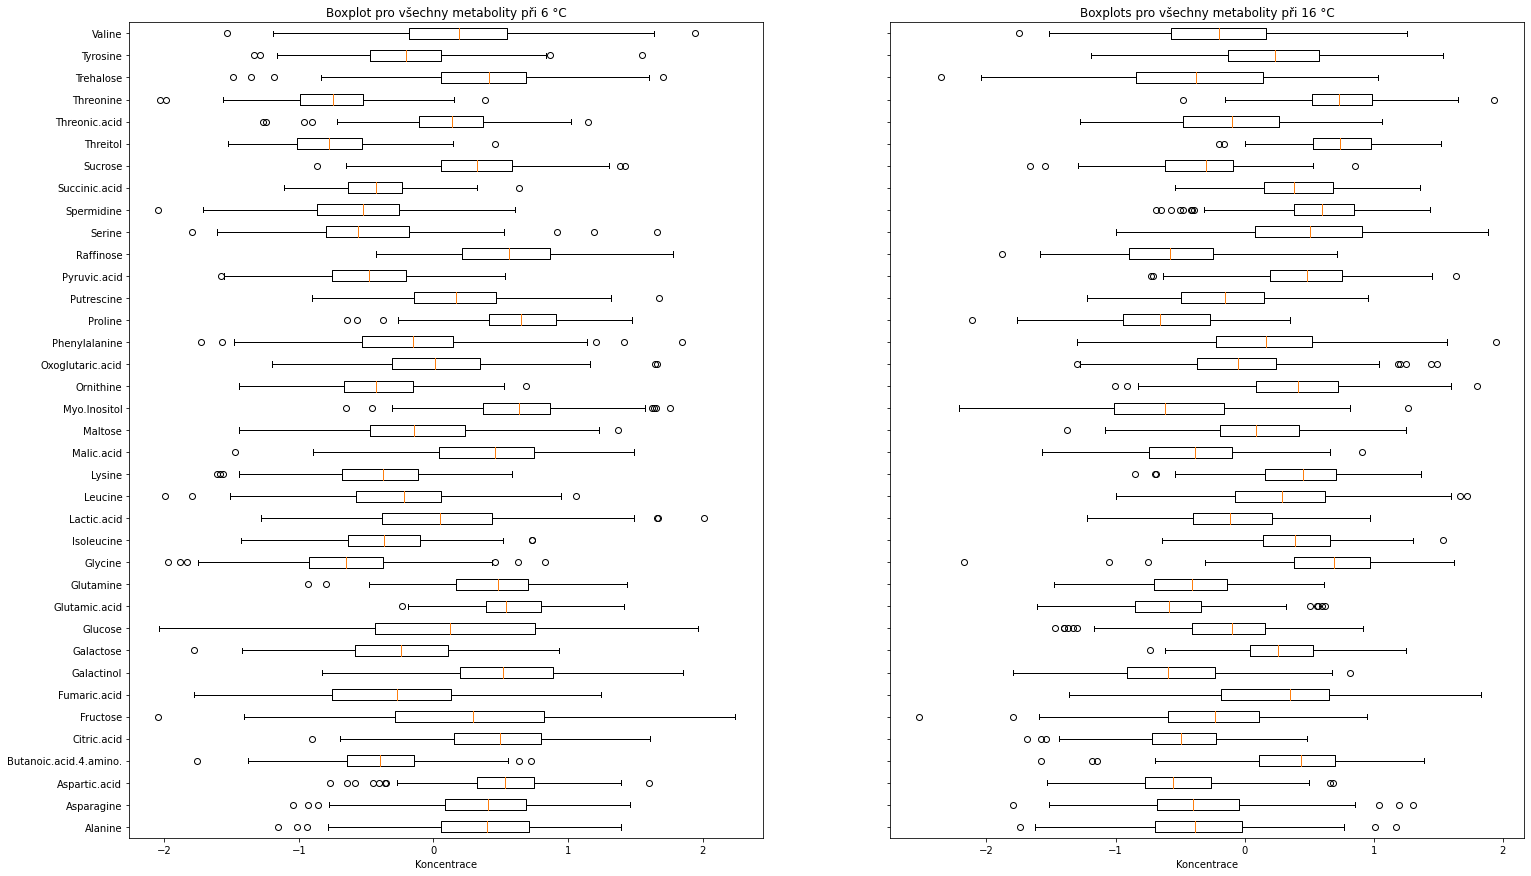

In [88]:
# Vytvoření dvou podgrafů vedle sebe
fig, axes = plt.subplots(1, 2, figsize=(25, 15), sharey=True)  

# Boxplot pro 6 °C
axes[0].boxplot(extract_6_degree_c, vert=False)
axes[0].set_title('Boxplot pro všechny metabolity při 6 °C')
axes[0].set_yticks(range(1, len(names_of_metabolites) + 1))
axes[0].set_yticklabels(names_of_metabolites)
axes[0].set_xlabel('Koncentrace')

# Boxplot pro 16 °C
axes[1].boxplot(extract_16_degree_c, vert=False)
axes[1].set_title('Boxplots pro všechny metabolity při 16 °C')
axes[1].set_yticks(range(1, len(names_of_metabolites) + 1))
axes[1].set_yticklabels(names_of_metabolites)
axes[1].set_xlabel('Koncentrace')


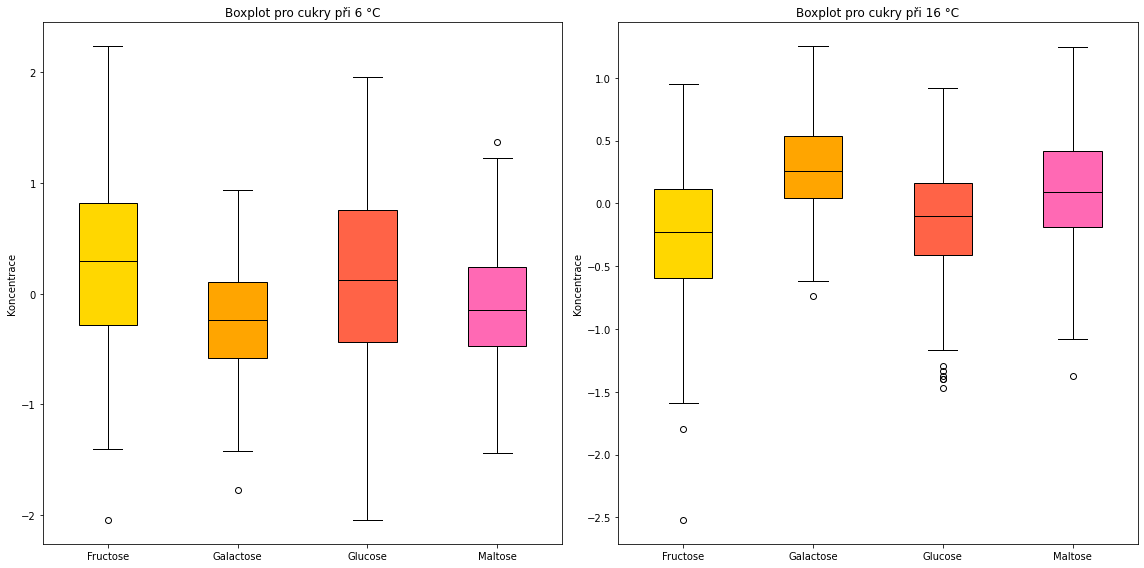

In [89]:
# Boxploty pro koncentrace cukrů při dvou teplotách
colors = ['#FFD700', '#FFA500', '#FF6347', '#FF69B4']  # Barvy pro jednotlivé boxploty (pro 4 cukry)

# Vytvoření figure a dvou axes (jeden graf pro každou teplotu)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 řádek, 2 sloupce

# Funkce pro vykreslení barevného boxplotu
def colorful_boxplot(ax, data, title):
    """
    Vykreslí boxplot s barevnými boxy na zadanou osu.

    Parametry:
        ax (matplotlib.axes.Axes): Matplotlib osa, kam se vykreslí graf.
        data (np.ndarray nebo list): Data pro boxplot (2D pole, kde každý sloupec představuje jednu proměnnou).
        title (str): Název grafu (momentálně se v rámci funkce nepoužívá).

    Návratová hodnota:
        None
    """
    bp = ax.boxplot(data, patch_artist=True)  # patch_artist=True umožní barvit boxy

    # Nastavení barev boxů
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Vykreslení středových čar (medián)
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(1)

# Vykreslení boxplotu pro 6 °C
colorful_boxplot(axes[0], data_sugar_6, 'Cukry při 6 °C')
axes[0].set_title('Boxplot pro cukry při 6 °C')
axes[0].set_xticks(range(1, len(metabolites_sugar) + 1))
axes[0].set_xticklabels(metabolites_sugar)
axes[0].set_ylabel('Koncentrace')

# Vykreslení boxplotu pro 16 °C
colorful_boxplot(axes[1], data_sugar_16, 'Cukry při 16 °C')
axes[1].set_title('Boxplot pro cukry při 16 °C')
axes[1].set_ylabel('Koncentrace')
axes[1].set_xticks(range(1, len(metabolites_sugar) + 1))
axes[1].set_xticklabels(metabolites_sugar)

# Uspořádání grafů, aby se nepřekrývaly
plt.tight_layout()

# Uložení obrázku (volitelně odkomentovat)
# plt.savefig('boxplot_sugars.png', dpi=300, transparent=True)

# Zobrazení grafu
plt.show()

### Rozdělení na trénovací a testovací sadu

In [90]:
# Rozdělení dat na trénovací a testovací sady (poměr 80 % trénink / 20 % test)

# Pro data naměřená při 6 °C
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(
    c_6_degree,        # Vstupní data (metabolity)
    rgr_6_degree,      # Výstupní data (růstová rychlost)
    test_size=0.2      # 20 % dat bude použito jako testovací sada
)

# Pro data naměřená při 16 °C
X_train_16, X_test_16, y_train_16, y_test_16 = train_test_split(
    c_16_degree,
    rgr_16_degree,
    test_size=0.2
)

# Pro kombinovanou sadu dat z obou teplot
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    c_combined,
    rgr_combined,
    test_size=0.2
)

## Hodnocení modelu

In [91]:
def evaluate_model(prediction, y):
    """
    Vyhodnotí výkon regresního modelu pomocí různých metrik.

    Parametry:
        prediction (np.ndarray nebo list): Predikované hodnoty z modelu.
        y (np.ndarray nebo list): Skutečné (pravdivé) cílové hodnoty.

    Návratová hodnota:
        list: [accuracy, R², MAE, MSE, RMSE, SMAPE]
            - accuracy (float): Pearsonův korelační koeficient.
            - R² (float): Koeficient determinace (R-squared).
            - MAE (float): Průměrná absolutní chyba (Mean Absolute Error).
            - MSE (float): Střední kvadratická chyba (Mean Squared Error).
            - RMSE (float): Odmocnina střední kvadratické chyby (Root MSE).
            - SMAPE (float): Symetrická průměrná procentuální chyba (Symmetric Mean Absolute Percentage Error).
    """
    # Výpočet Pearsonova korelačního koeficientu (míra lineární závislosti)
    pearson_corr, _ = pearsonr(y, prediction)
    accuracy = pearson_corr

    # Výpočet běžných regresních metrik
    r2 = r2_score(y, prediction)                        # Koeficient determinace
    mae = mean_absolute_error(y, prediction)            # Průměrná absolutní chyba
    mse = mean_squared_error(y, prediction)             # Střední kvadratická chyba
    rmse = np.sqrt(mse)                                 # Odmocnina MSE
    smape = np.mean(                                    # Symetrická MAPE
        200 * np.abs(prediction - y) /
        (np.abs(prediction) + np.abs(y) + 1e-8)         # +1e-8 pro zabránění dělení nulou
    )

    return [accuracy, r2, mae, mse, rmse, smape]

## Trénování, testování a validace modelu

In [92]:
def train_models(models, X_train, y_train):
    """
    Trénuje modely a provede křížovou validaci (cross-validation) s metrikou MSE.

    Parametry:
        models (dict): Slovník modelů ve formátu {název_modelu: instance_modelu}.
        X_train (np.ndarray): Vstupní trénovací data.
        y_train (np.ndarray): Výstupní hodnoty (cíle) pro trénovací data.

    Návratová hodnota:
        tuple:
            - trained_models (dict): Slovník natrénovaných modelů.
            - cv_results (dict): Výsledky křížové validace}.
    """
    trained_models = {}
    cv_results = {}

    for name, model in models.items():
        # 5-násobná křížová validace s metrikou MSE
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        cv_mean = -np.mean(cv_scores)
        cv_results[name] = cv_mean

        # Trénování modelu na celém trénovacím datasetu
        model.fit(X_train, y_train)
        trained_models[name] = model

    return trained_models, cv_results

In [93]:
def test_models(trained_models, X_train, X_test, y_test, cv_results, dataset_name):
    """
    Testuje modely na testovacích datech a vyhodnocuje jejich výkon.

    Parametry:
        trained_models (dict): Slovník již natrénovaných modelů.
        X_train (np.ndarray): Trénovací vstupní data (pro výpočet mediánu).
        X_test (np.ndarray): Testovací vstupní data.
        y_test (np.ndarray): Skutečné výstupy pro testovací data.
        cv_results (dict): Výsledky cross-validace.
        dataset_name (str): Popisek datasetu (pro tabulku výstupů).

    Návratová hodnota:
        tuple:
            - df_results (pd.DataFrame): Tabulka metrik pro každý model.
            - all_preds (dict): Predikce (binární) modelů podle mediánu.
            - y_test_binary (dict): Skutečné hodnoty (binární, podle mediánu).
    """
    results = []
    all_preds = {}
    y_test_binary = {}

    for name, model in trained_models.items():
        # Regresní predikce
        y_pred_reg = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        # Binarizace na základě mediánu predikcí na trénovacích datech
        median_threshold = np.median(y_pred_train)
        y_pred = (y_pred_reg > median_threshold).astype(int)
        y_test_bin = (y_test > median_threshold).astype(int)

        all_preds[name] = y_pred
        y_test_binary[name] = y_test_bin

        # Vyhodnocení regresních predikcí
        metrics = evaluate_model(y_pred_reg, y_test)
        cv_mean = cv_results[name]

        # Uložení výsledků
        results.append([name, dataset_name] + metrics + [cv_mean])

    # Tabulka výsledků ve formátu pandas DataFrame
    df_results = pd.DataFrame(
        results,
        columns=[
            "Model",
            "Teplota a metoda",
            "Accuracy",   # Pearsonova korelace
            "R²",         # Determinační koeficient
            "MAE",        # Průměrná absolutní chyba
            "MSE",        # Střední kvadratická chyba
            "RMSE",       # Odmocnina MSE
            "SMAPE",      # Symetrická průměrná procentuální chyba
            "CV MSE Mean", # Průměrnáé MSE 
        ]
    )
    if not df_results.empty:
        print(df_results)


    return df_results, all_preds, y_test_binary



In [94]:
def train_test_model(models, X_train, X_test, y_train, y_test, dataset_name):
    """
    Trénuje a testuje všechny modely na zadaném datasetu.

    Parametry:
        models (dict): Slovník modelů.
        X_train (np.ndarray): Trénovací vstupní data.
        y_train (np.ndarray): Trénovací cílové hodnoty.
        X_test (np.ndarray): Testovací vstupní data.
        y_test (np.ndarray): Testovací cílové hodnoty.
        dataset_name (str): Název kombinace datasetu pro identifikaci výsledků.

    Návratová hodnota:
        tuple: 
            - df_results (pd.DataFrame): Výsledky evaluace modelů.
            - all_preds (dict): Binární predikce jednotlivých modelů.
            - y_test_binary (dict): Binární skutečné hodnoty jednotlivých modelů.
    """
    # Trénink + validace
    trained_models, cv_results = train_models(models, X_train, y_train)
    # Testování + vyhodnocení
    df_results,all_preds, y_test_binary = test_models(trained_models, X_train, X_test, y_test, cv_results, dataset_name)

    return df_results, all_preds, y_test_binary



In [95]:
# Vypsání výsedků
result_6_6, all_preds_6_6,y_test_binary_6_6 = train_test_model(
    models, 
    X_train_6, 
    X_test_6, 
    y_train_6, 
    y_test_6, 
    "6°C → 6°C"
)
result_6_16, all_preds_6_16,y_test_binary_6_16 = train_test_model(
    models, 
    X_train_6, 
    X_test_16, 
    y_train_6, 
    y_test_16, 
    "6°C → 16°C"
)
result_16_6, all_preds_16_6,y_test_binary_16_6 = train_test_model(
    models, 
    X_train_16, 
    X_test_6, 
    y_train_16, 
    y_test_6, 
    "16°C → 6°C"
)
result_16_16, all_preds_16_16,y_test_binary_16_16 = train_test_model(
    models, 
    X_train_16, 
    X_test_16, 
    y_train_16, 
    y_test_16, 
    "16°C → 16°C"
)

result_com, all_preds_com,y_test_binary_com = train_test_model(
    models, 
    X_train_combined, 
    X_test_combined, 
    y_train_combined, 
    y_test_combined,
    "6°C+16°C → 6°C+16°C"
)

                       Model Teplota a metoda  Accuracy        R²       MAE  \
0    Random Forest Regressor        6°C → 6°C  0.328188 -0.004916  0.002302   
1          Linear Regression        6°C → 6°C  0.415505 -0.068085  0.002293   
2  Support Vector Regression        6°C → 6°C  0.382730 -0.070155  0.002399   

        MSE      RMSE     SMAPE  CV MSE Mean  
0  0.000009  0.003077  4.401713     0.000015  
1  0.000010  0.003172  4.364455     0.000016  
2  0.000010  0.003175  4.588452     0.000015  
                       Model Teplota a metoda  Accuracy         R²       MAE  \
0    Random Forest Regressor       6°C → 16°C  0.363613 -70.580814  0.111901   
1          Linear Regression       6°C → 16°C  0.208524 -72.661373  0.113540   
2  Support Vector Regression       6°C → 16°C  0.212347 -75.173051  0.115455   

        MSE      RMSE       SMAPE  CV MSE Mean  
0  0.012692  0.112659   99.262790     0.000015  
1  0.013061  0.114285  101.538205     0.000016  
2  0.013506  0.116217  104.

## Detekce koncept driftu

### DDM

In [96]:
def detect_ddm(y_test_binary, all_preds, temperature, ecotypes):
    """
    Detekuje drift pomocí metody DDM (Drift Detection Method).

    Parametry:
        y_test_binary (dict): Skutečné binární hodnoty pro jednotlivé modely.
        all_preds (dict): Predikované binární hodnoty modelů.
        temperature (str): Popis teplotní kombinace (např. "6°C → 16°C").
        ecotypes (list): Seznam názvů ekotypů ve stejném pořadí jako testovací vzorky.

    ávratová hodnota:
        dict: Indexy driftů pro každý model ve formátu {název_modelu: [indexy_driftů]}.
    """
    
    # Inicializace přehledové tabulky a slovníku výsledků
    summary_results = []
    drift_indices_dict = {}

    # Iterace přes každý model a jeho predikce
    for model_name, y_pred_binary in all_preds.items():
        ddm = DDM()                   # Inicializace DDM detektoru
        drift_points = []            # Indexy detekovaných driftů
        warning_points = []          # Indexy varovných zón
        drift_ecotypes = []          # Ekotypy při výskytu driftu

        y_true_binary = y_test_binary[model_name]  # Skutečné binární hodnoty

        # Iterace přes všechny predikce (vzorky)
        for i in range(len(y_true_binary)):

            # Výpočet chyby (1 = špatně, 0 = správně)
            error = 0 if y_pred_binary[i] == y_true_binary[i] else 1
            
            # Přidání chyby do DDM
            ddm.add_element(error)

            # Detekce varovné zóny
            if ddm.detected_warning_zone():
                warning_points.append(i)

            # Detekce driftní změny
            if ddm.detected_change():
                drift_points.append(i)
                drift_ecotypes.append(ecotypes[i])

        # Uložení výsledků driftu pro daný model
        drift_indices_dict[model_name] = drift_points

        # Shromáždění výsledků pro přehled
        summary_results.append([
            model_name,
            temperature,
            len(warning_points),
            len(drift_points),
            warning_points,
            drift_points,
            drift_ecotypes
        ])
        #if not any(drift_indices_dict.values()):
          #  return drift_indices_dict
        
    # Vytvoření DataFrame pro přehledný výstup
    df_drift = pd.DataFrame(
        summary_results,
        columns=[
            "Model",
            "Teplota a metoda",
            "Počet varování",
            "Počet driftů",
            "Indexy varování",
            "Indexy driftů",
            "Ekotyp driftu"
        ]
    )

    print(df_drift)
    return drift_indices_dict




In [97]:
# Volání funkce detect_ddm
drift_indices_ddm_6_6 = detect_ddm(
    y_test_binary_6_6, 
    all_preds_6_6,
    "6°C → 6°C DDM",
    names_of_ecotypes
)
drift_indices_ddm_6_16 = detect_ddm(
    y_test_binary_6_16, 
    all_preds_6_16,
    "6°C → 16°C DDM",
    names_of_ecotypes
)
drift_indices_ddm_16_16 = detect_ddm(
    y_test_binary_16_16, 
    all_preds_16_16,
    "16°C → 16°C DDM",
    names_of_ecotypes
)
drift_indices_ddm_16_6 = detect_ddm(
    y_test_binary_16_6, 
    all_preds_16_6,
    "16°C → 6°C DDM",
    names_of_ecotypes
)
drift_indices_ddm_com = detect_ddm(
    y_test_binary_com, 
    all_preds_com,
    "6°C+16°C → 6°C+16°C DDM",
    names_combined
)

                       Model Teplota a metoda  Počet varování  Počet driftů  \
0    Random Forest Regressor    6°C → 6°C DDM               0             0   
1          Linear Regression    6°C → 6°C DDM               0             0   
2  Support Vector Regression    6°C → 6°C DDM               0             0   

  Indexy varování Indexy driftů Ekotyp driftu  
0              []            []            []  
1              []            []            []  
2              []            []            []  
                       Model Teplota a metoda  Počet varování  Počet driftů  \
0    Random Forest Regressor   6°C → 16°C DDM               0             0   
1          Linear Regression   6°C → 16°C DDM               0             0   
2  Support Vector Regression   6°C → 16°C DDM               0             0   

  Indexy varování Indexy driftů Ekotyp driftu  
0              []            []            []  
1              []            []            []  
2              []            [

### EDDM

In [98]:
def detect_eddm(y_test_binary, all_preds, temperature, ecotypes):
    """
    Detekuje drift pomocí metody EDDM (Early Drift Detection Method).

    Parametry:
        y_test_binary (dict): Skutečné binární hodnoty pro jednotlivé modely.
        all_preds (dict): Predikované binární hodnoty jednotlivých modelů.
        temperature (str): Popis teplotní kombinace (např. "6°C → 16°C").
        ecotypes (list): Seznam názvů ekotypů odpovídajících pořadí testovacích vzorků.

    Návratová hodnota:
        dict: Slovník indexů driftových bodů pro každý model ve formátu {název_modelu: [indexy_driftů]}.
    """
    
    # Inicializace výstupních struktur
    summary_results = []
    drift_indices_dict = {}

    # Iterace přes všechny modely a jejich predikce
    for model_name, y_pred_binary in all_preds.items():
        eddm = EDDM()                # Inicializace EDDM detektoru
        drift_points = []           # Indexy detekovaných driftů
        warning_points = []         # Indexy varovných zón
        drift_ecotypes = []         # Názvy ekotypů, kde nastal drift

        y_true_binary = y_test_binary[model_name]  # Skutečné binární hodnoty

        # Projde každý vzorek v testovací sadě
        for i in range(len(y_true_binary)):

            # Určení chyby predikce
            error = 0 if y_pred_binary[i] == y_true_binary[i] else 1

            # Předání chyby do EDDM
            eddm.add_element(error)

            # Pokud je detekována varovná zóna
            if eddm.detected_warning_zone():
                warning_points.append(i)

            # Pokud je detekován drift (změna)
            if eddm.detected_change():
                drift_points.append(i)
                drift_ecotypes.append(ecotypes[i])

        # Uložení detekovaných driftů do výstupního slovníku
        drift_indices_dict[model_name] = drift_points

        # Přidání přehledových dat do tabulky
        summary_results.append([
            model_name,
            temperature,
            len(warning_points),
            len(drift_points),
            warning_points,
            drift_points,
            drift_ecotypes
        ])
        
       # if not any(drift_indices_dict.values()):
           # return drift_indices_dict  # Pokud nejsou detekovány žádné drifty, vrátí prázdný slovník

    # Vytvoření pandas DataFrame pro srozumitelný výstup
    df_drift = pd.DataFrame(
        summary_results,
        columns=[
            "Model",
            "Teplota a metoda",
            "Počet varování",
            "Počet driftů",
            "Indexy varování",
            "Indexy driftů",
            "Ekotyp driftu"
        ]
    )
    
    print(df_drift)
    return drift_indices_dict


In [99]:
# Volání funkce detect_eddm
drift_indices_eddm_6_6 = detect_eddm(
    y_test_binary_6_6, 
    all_preds_6_6,
    "6°C → 6°C EDDM",
    names_of_ecotypes
)
drift_indices_eddm_6_16 = detect_eddm(
    y_test_binary_6_16, 
    all_preds_6_16,
    "6°C → 16°C EDDM",
    names_of_ecotypes
)
drift_indices_eddm_16_16 = detect_eddm(
    y_test_binary_16_16, 
    all_preds_16_16,
    "16°C → 16°C EDDM",
    names_of_ecotypes
)
drift_indices_eddm_16_6 = detect_eddm(
    y_test_binary_16_6, 
    all_preds_16_6,
    "16°C → 6°C EDDM",
    names_of_ecotypes
)
drift_indices_eddm_com = detect_eddm(
    y_test_binary_com, 
    all_preds_com,
    "6°C+16°C → 6°C+16°C EDDM",
    names_combined
)

                       Model Teplota a metoda  Počet varování  Počet driftů  \
0    Random Forest Regressor   6°C → 6°C EDDM               0             0   
1          Linear Regression   6°C → 6°C EDDM               0             0   
2  Support Vector Regression   6°C → 6°C EDDM               0             0   

  Indexy varování Indexy driftů Ekotyp driftu  
0              []            []            []  
1              []            []            []  
2              []            []            []  
                       Model Teplota a metoda  Počet varování  Počet driftů  \
0    Random Forest Regressor  6°C → 16°C EDDM               0             0   
1          Linear Regression  6°C → 16°C EDDM               0             0   
2  Support Vector Regression  6°C → 16°C EDDM               0             0   

  Indexy varování Indexy driftů Ekotyp driftu  
0              []            []            []  
1              []            []            []  
2              []            [

 ### Vizualizace detekovaných koncept driftů 

In [100]:
def heatmap_sugar_concentration(drift_indices, data_sugar_6, data_sugar_16, method, temperature, ecotypes):
    """
    Vykreslí heatmapy koncentrací cukrů při 6 °C a 16 °C
    a označí detekované driftové body pro jednotlivé modely.

    Parametry:
        drift_indices (dict): Slovník s názvy modelů jako klíči a seznamy indexů driftových vzorků jako hodnotami.
        data_sugar_6 (np.ndarray): Matice koncentrací cukrů při 6 °C (vzorky x metabolity).
        data_sugar_16 (np.ndarray): Matice koncentrací cukrů při 16 °C (vzorky x metabolity).
        method (str): Název použité metody detekce driftu (např. "DDM", "EDDM").
        temperature (str): Popis teplotních podmínek (např. "6°C → 16°C").
        ecotypes (list): Seznam názvů ekotypů odpovídajících jednotlivým vzorkům.

    Návratová hodnota:
        None: Funkce vykreslí grafy a nevrací žádnou hodnotu.
    """
    
    # Určení minimálních a maximálních hodnot pro každý metabolit
    min_6 = np.min(data_sugar_6, axis=0)
    max_6 = np.max(data_sugar_6, axis=0)
    min_16 = np.min(data_sugar_16, axis=0)
    max_16 = np.max(data_sugar_16, axis=0)

    # Globální rozsah barevné škály
    vmin = min(np.min(min_6), np.min(min_16))
    vmax = max(np.max(max_6), np.max(max_16))

    # Příprava interpolovaných matic pro heatmapy
    matrix_6 = np.array([np.linspace(mn, mx, 239) for mn, mx in zip(min_6, max_6)])
    matrix_16 = np.array([np.linspace(mn, mx, 239) for mn, mx in zip(min_16, max_16)])

    for model_name, drift_list in drift_indices.items():
        
        if not drift_list:
            continue

        plt.figure(figsize=(14, 7))

        # --- Heatmapa pro 6 °C ---
        plt.subplot(1, 2, 1)
        ax1 = sns.heatmap(
            matrix_6.T,
            cmap="coolwarm",
            xticklabels=metabolites_sugar,
            yticklabels=False,
            cbar_kws={"label": "Koncentrace metabolitů"},
            vmin=vmin,
            vmax=vmax
        )
        cbar = ax1.collections[0].colorbar  # přístup ke colorbaru
        cbar.ax.tick_params(labelsize=12)   # velikost čísel na škále
        cbar.ax.set_ylabel("Koncentrace metabolitů", fontsize=14) 
        ax1.set_title("Koncentrace cukrů pro 6 °C", fontsize=14)
        ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=14)
        plt.gca().invert_yaxis()

        # --- Vyznačení driftů na 6 °C ---
        for idx, metabolite in enumerate(metabolites_sugar):
            for drift in drift_list:
                conc = data_sugar_6[drift][idx]
                y_pos = np.abs(np.linspace(min_6[idx], max_6[idx], 239) - conc).argmin()
                ecotype = ecotypes[drift][3:]
                
                legend_dummy = Line2D(
                    [0], 
                    [0], 
                    color='none', 
                    label='Koncentrace \n Ekotyp'
                )
                ax1.legend(
                    handles=[legend_dummy],
                    loc='lower center',
                    bbox_to_anchor=(0.80, 0.0),
                    frameon=True,                    
                    edgecolor='black',              
                    facecolor='white',              
                    fontsize=14
                )
                ax1.hlines(y=y_pos, 
                           xmin=idx, 
                           xmax=idx + 1, 
                           color='black', 
                           linewidth=2, 
                           zorder=14
                          )
                ax1.text(
                    x=idx + 0.5, y=y_pos + 2,
                    s=f"{conc:.2f}\n{ecotype}",
                    ha="center", va="bottom", fontsize=14,
                    color="black", zorder=16
                )

        # --- Heatmapa pro 16 °C ---
        plt.subplot(1, 2, 2)
        ax2 = sns.heatmap(
            matrix_16.T,
            cmap="coolwarm",
            xticklabels=metabolites_sugar,
            yticklabels=False,
            cbar_kws={"label": "Koncentrace metabolitů"},
            vmin=vmin,
            vmax=vmax
        )
        cbar = ax2.collections[0].colorbar  # přístup ke colorbaru
        cbar.ax.tick_params(labelsize=12)   # velikost čísel na škále
        cbar.ax.set_ylabel("Koncentrace metabolitů", fontsize=14) 
        ax2.set_title("Koncentrace cukrů pro 16 °C", fontsize=14)
        ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=14)
        plt.gca().invert_yaxis()

        # --- Vyznačení driftů na 16 °C ---
        for idx, metabolite in enumerate(metabolites_sugar):
            for drift in drift_list:
                conc = data_sugar_16[drift][idx]
                y_pos = np.abs(np.linspace(min_16[idx], max_16[idx], 239) - conc).argmin()
                ecotype = ecotypes[drift][3:]
                ax2.hlines(
                    y=y_pos, 
                    xmin=idx, 
                    xmax=idx + 1, 
                    color='black', 
                    linewidth=2, 
                    zorder=14
                )
                ax2.text(
                    x=idx + 0.5, y=y_pos + 2,
                    s=f"{conc:.2f}\n{ecotype}",
                    ha="center", va="bottom", fontsize=14,
                    color="black", zorder=14
                )
                legend_dummy = Line2D(
                    [0], 
                    [0], 
                    color='none', 
                    label='Koncentrace \n Ekotyp'
                )
                ax2.legend(
                    handles=[legend_dummy],
                    loc='lower center',
                    bbox_to_anchor=(0.80, 0.0),
                    frameon=True,                    
                    edgecolor='black',              
                    facecolor='white',              
                    fontsize=14
                )
            

        # --- Celkový nadpis a vykreslení ---
        plt.suptitle(
            f"Detekce driftu pomocí metody {method}\nModel: {model_name} | Teploty: {temperature}",
            fontsize=16, y=1.05
        )
        plt.tight_layout()
        plt.show()



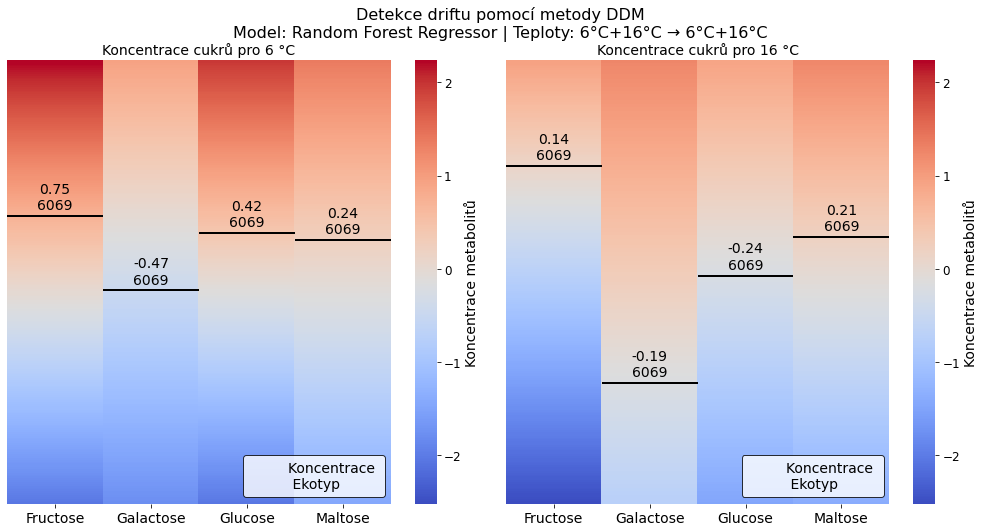

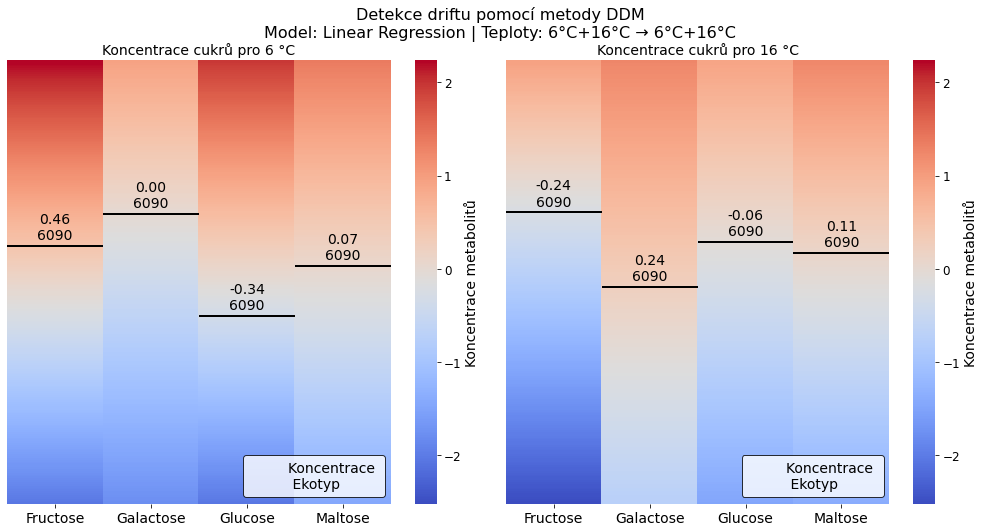

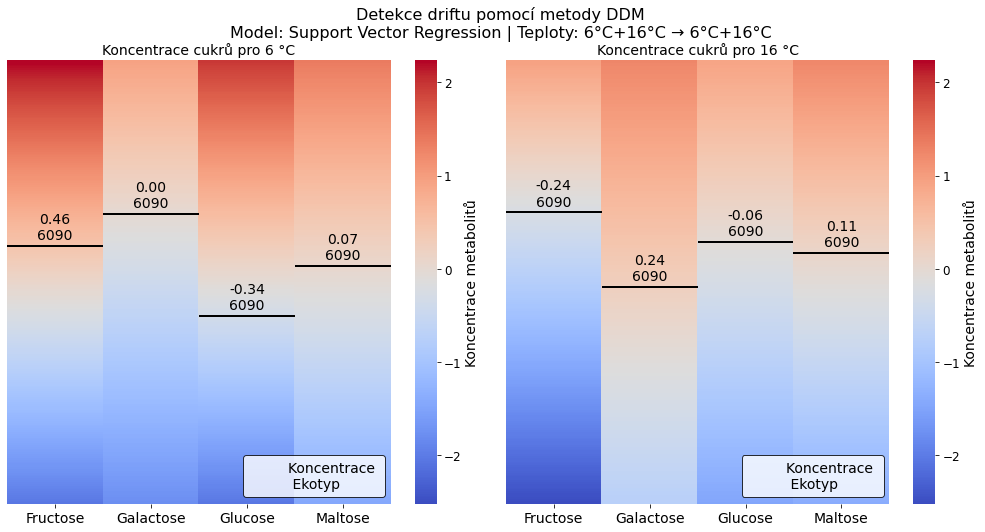

In [101]:
# Volání funkce heatmap
heatmap_ddm_6_6 = heatmap_sugar_concentration(
    drift_indices_ddm_6_6, 
    data_sugar_6, 
    data_sugar_16, 
    "DDM",
    "6°C → 6°C",
    names_of_ecotypes
)
heatmap_ddm_6_16 = heatmap_sugar_concentration(
    drift_indices_ddm_6_16, 
    data_sugar_6, 
    data_sugar_16, 
    "DDM",
    "6°C → 16°C",
    names_of_ecotypes
)
heatmap_ddm_16_16 = heatmap_sugar_concentration(
    drift_indices_ddm_16_16, 
    data_sugar_6, 
    data_sugar_16, 
    "DDM",
    "16°C → 16°C",
    names_of_ecotypes
)
heatmap_ddm_16_6 = heatmap_sugar_concentration(
    drift_indices_ddm_16_6, 
    data_sugar_6, 
    data_sugar_16, 
    "DDM",
    "16°C → 6°C",
    names_of_ecotypes
)
heatmap_ddm_com = heatmap_sugar_concentration(
    drift_indices_ddm_com, 
    data_sugar_6, 
    data_sugar_16,
    "DDM",
    "6°C+16°C → 6°C+16°C",
    names_of_ecotypes
)
heatmap_eddm_6_6 = heatmap_sugar_concentration(
    drift_indices_eddm_6_6, 
    data_sugar_6, 
    data_sugar_16, 
    "EDDM",
    "6°C → 6°C",
    names_of_ecotypes
)
heatmap_eddm_6_16 = heatmap_sugar_concentration(
    drift_indices_eddm_6_16, 
    data_sugar_6, 
    data_sugar_16, 
    "EDDM",
    "6°C → 16°C",
    names_of_ecotypes
)
heatmap_eddm_16_16 = heatmap_sugar_concentration(
    drift_indices_eddm_16_16, 
    data_sugar_6, 
    data_sugar_16, 
    "EDDM",
    "16°C → 16°C",
    names_of_ecotypes
)
heatmap_eddm_16_6 = heatmap_sugar_concentration(
    drift_indices_eddm_16_6, 
    data_sugar_6, 
    data_sugar_16, 
    "EDDM",
    "16°C → 6°C",
    names_of_ecotypes
)
heatmap_eddm_com = heatmap_sugar_concentration(
    drift_indices_eddm_com, 
    data_sugar_6, 
    data_sugar_16,
    "EDDM",
    "6°C+16°C → 6°C+16°C",
    names_of_ecotypes
)

# Korekce koncept driftu 


## Retrénování modelu

In [102]:
def retrain_models_on_drift(models, drift_indices_dict, X_train, y_train, X_test, y_test, append_to_train=True):
    """
    Přeučí modely na základě detekovaného driftu.

    Parametry:
        models (dict): Slovník modelů ve tvaru {název_modelu: model}.
        drift_indices_dict (dict): Slovník indexů driftových vzorků pro každý model.
        X_train (np.ndarray): Trénovací vstupní data.
        y_train (np.ndarray): Trénovací cílové hodnoty.
        X_test (np.ndarray): Testovací vstupní data.
        y_test (np.ndarray): Testovací cílové hodnoty.
        append_to_train (bool): Určuje, zda přidat driftové vzorky k trénovacím datům (výchozí: True).

    Návratová hodnota:
        tuple:
            updated_models (dict): Slovník s přeučenými modely.
            X_train (np.ndarray): Aktualizovaná trénovací data (pokud append_to_train je True).
            y_train (np.ndarray): Aktualizované trénovací cílové hodnoty.
            cv_results (dict): Výsledky křížové validace pro každý model (průměrné MSE).
    """
    # Inicializace slovníku pro nové modely
    updated_models = {}

    # Inicializace slovníku pro výsledky křížové validace
    cv_results = {}

    # Prochází všechny modely v předaném slovníku
    for name, model in models.items():
        # Získá indexy driftových vzorků pro aktuální model
        drift_indices = drift_indices_dict.get(name, [])

        # Vypočte skóre R² pomocí křížové validace na trénovacích datech
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        cv_mean = -np.mean(cv_scores) 
        cv_results[name] = cv_mean

        # Vybere data odpovídající driftovým indexům z testovacích dat
        X_drift = X_test[drift_indices]
        y_drift = y_test[drift_indices]

        # Ujistí se, že vstupní data mají správný rozměr pro trénování
        if X_drift.ndim == 1:
            X_drift = X_drift.reshape(1, -1)
        if y_drift.ndim > 1:
            y_drift = y_drift.ravel()

        # Pokud je append_to_train True, připojí driftová data k trénovacím datům
        if append_to_train:
            X_train_new = np.vstack([X_train, X_drift])
            y_train_new = np.hstack([y_train, y_drift])
        else:
            # Jinak použije pouze driftová data
            X_train_new = X_drift
            y_train_new = y_drift

        # Informace o přeučení modelu s počtem vzorků
        
        (f"{name}: Přetrénování modelu - {len(X_drift)} drift detekován.")

        # Klonuje původní model a natrénuje ho na nových datech
        new_model = clone(model)
        new_model.fit(X_train_new, y_train_new)

        # Uloží nový model do slovníku
        updated_models[name] = new_model

        # Pokud připojuje data, aktualizuje hlavní trénovací data pro další iterace
        if append_to_train:
            X_train = X_train_new
            y_train = y_train_new

    return updated_models, X_train, y_train, cv_results

In [103]:
def retrain_and_test_models(models, drift_indices_dict, X_train, y_train, X_test, y_test, dataset_name, append_to_train=True):
    """
    Přetrénuje modely na datech s detekovaným driftem a otestuje je.

    Parametry:
        models (dict): Slovník modelů {jméno: model}, které podporují trénování.
        drift_indices_dict (dict): Slovník s názvy modelů jako klíči a seznamy indexů driftu jako hodnotami.
        X_train (np.ndarray): Trénovací vstupní data.
        y_train (np.ndarray): Trénovací cílové hodnoty.
        X_test (np.ndarray): Testovací vstupní data.
        y_test (np.ndarray): Testovací cílové hodnoty.
        dataset_name (str): Název datasetu pro tisk výsledků.
        append_to_train (bool): Určuje, zda přidat driftová data k trénovací množině.

    Návratová hodnota:
        tuple: 
            df_results (pandas.DataFrame): Výsledky evaluace na testovacích datech.
            all_preds (dict): Binarizované predikce modelů.
            y_test_binary (dict): Binarizované skutečné štítky testovacích dat.
            updated_models (dict): Modely po přetrénování.
            X_train_updated (np.ndarray): Aktualizovaná trénovací data.
            y_train_updated (np.ndarray): Aktualizované trénovací cílové hodnoty.
    """
    updated_models, X_train_updated, y_train_updated, cv_results = retrain_models_on_drift(
        models, 
        drift_indices_dict, 
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        append_to_train=append_to_train
    )

    df_results, all_preds, y_test_binary = test_models(
        updated_models, 
        X_train_updated, 
        X_test, 
        y_test, 
        cv_results, 
        dataset_name
    )

    return df_results, all_preds, y_test_binary, updated_models, X_train_updated, y_train_updated


In [104]:
# Přetrénování a testování modelů pro různé kombinace teplot a metod (DDM, EDDM)
# Pro každý scénář použijeme funkci retrain_and_test_models s odpovídajícími daty a drift indexy.

# 6°C → 6°C
df_results_6_6, all_preds_6_6, y_test_binary_6_6, updated_models_6_6, X_train_6_updated, y_train_6_updated = retrain_and_test_models(
    models,
    drift_indices_ddm_6_6,
    X_train_6,
    y_train_6,
    X_test_6,
    y_test_6,
    "6°C → 6°C DDM",
    append_to_train=True
)

# 6°C → 16°C
df_results_6_16, all_preds_6_16, y_test_binary_6_16, updated_models_6_16, X_train_6_16_updated, y_train_6_16_updated = retrain_and_test_models(
    models,
    drift_indices_ddm_6_16,
    X_train_6,
    y_train_6,
    X_test_16,
    y_test_16,
    "6°C → 16°C DDM",
    append_to_train=True
)

# 16°C → 6°C
df_results_16_6, all_preds_16_6, y_test_binary_16_6, updated_models_16_6, X_train_16_6_updated, y_train_16_6_updated = retrain_and_test_models(
    models,
    drift_indices_ddm_16_6,
    X_train_16,
    y_train_16,
    X_test_6,
    y_test_6,
    "16°C → 6°C DDM",
    append_to_train=True
)

# 16°C → 16°C
df_results_16_16, all_preds_16_16, y_test_binary_16_16, updated_models_16_16, X_train_16_updated, y_train_16_16_updated = retrain_and_test_models(
    models,
    drift_indices_ddm_16_16,
    X_train_16,
    y_train_16,
    X_test_16,
    y_test_16,
    "16°C → 16°C DDM",
    append_to_train=True
)

# Kombinované 6°C + 16°C → 6°C + 16°C
df_results_com, all_preds_com, y_test_binary_com, updated_models_com, X_train_com_updated, y_train_com_updated = retrain_and_test_models(
    models,
    drift_indices_ddm_com,
    X_train_combined,
    y_train_combined,
    X_test_combined,
    y_test_combined,
    "6°C + 16°C → 6°C + 16°C DDM",
    append_to_train=True
)

# Stejné scénáře pro metodu EDDM (bez deepcopy, pokud to není nutné)
df_results_eddm_6_6, all_preds_eddm_6_6, y_test_binary_eddm_6_6, updated_models_eddm_6_6, X_train_eddm_6_updated, y_train_eddm_6_updated = retrain_and_test_models(
    models,
    drift_indices_eddm_6_6,
    X_train_6,
    y_train_6,
    X_test_6,
    y_test_6,
    "6°C → 6°C EDDM",
    append_to_train=True
)
df_results_eddm_6_16, all_preds_eddm_6_16, y_test_binary_eddm_6_16, updated_models_eddm_6_16, X_train_eddm_6_16_updated, y_train_eddm_6_16_updated = retrain_and_test_models(
    models,
    drift_indices_eddm_6_16,
    X_train_6,
    y_train_6,
    X_test_16,
    y_test_16,
    "6°C → 16°C EDDM",
    append_to_train=True
)
df_results_eddm_16_6, all_preds_eddm_16_6, y_test_binary_eddm_16_6, updated_models_eddm_16_6, X_train_eddm_16_6_updated, y_train_eddm_16_6_updated = retrain_and_test_models(
    models,
    drift_indices_eddm_16_6,
    X_train_16,
    y_train_16,
    X_test_6,
    y_test_6,
    "16°C → 6°C EDDM",
    append_to_train=True
)
df_results_eddm_16_16, all_preds_eddm_16_16, y_test_binary_eddm_16_16, updated_models_eddm_16_16, X_train_eddm_16_updated, y_train_eddm_16_16_updated = retrain_and_test_models(
    models,
    drift_indices_eddm_16_16,
    X_train_16,
    y_train_16,
    X_test_16,
    y_test_16,
    "16°C → 16°C EDDM",
    append_to_train=True
)
df_results_eddm_com, all_preds_eddm_com, y_test_binary_eddm_com, updated_models_eddm_com, X_train_eddm_com_updated, y_train_eddm_com_updated = retrain_and_test_models(
    models,
    drift_indices_eddm_com,
    X_train_combined,
    y_train_combined,
    X_test_combined,
    y_test_combined,
    "6°C + 16°C → 6°C + 16°C EDDM",
    append_to_train=True
)

                       Model Teplota a metoda  Accuracy        R²       MAE  \
0    Random Forest Regressor    6°C → 6°C DDM  0.416753  0.119084  0.002150   
1          Linear Regression    6°C → 6°C DDM  0.415505 -0.068085  0.002293   
2  Support Vector Regression    6°C → 6°C DDM  0.382730 -0.070155  0.002399   

        MSE      RMSE     SMAPE  CV MSE Mean  
0  0.000008  0.002881  4.106720     0.000016  
1  0.000010  0.003172  4.364455     0.000016  
2  0.000010  0.003175  4.588452     0.000015  
                       Model Teplota a metoda  Accuracy         R²       MAE  \
0    Random Forest Regressor   6°C → 16°C DDM  0.455871 -71.694441  0.112781   
1          Linear Regression   6°C → 16°C DDM  0.208524 -72.661373  0.113540   
2  Support Vector Regression   6°C → 16°C DDM  0.212347 -75.173051  0.115455   

        MSE      RMSE       SMAPE  CV MSE Mean  
0  0.012890  0.113532  100.441284     0.000015  
1  0.013061  0.114285  101.538205     0.000016  
2  0.013506  0.116217  104.

## Škálování dat

In [107]:
def scale_data(data, method="none", y_labels=None):
    """
    Škáluje data zvolenou metodou.

    Parametry:
        data (np.ndarray): Vstupní data, která mají být škálována.
        method (str): Metoda škálování. Dostupné možnosti:
            - "none" (žádné škálování)
            - "standard" (autoscaling - standardizace)
            - "minmax" (škálování do intervalu <0,1>)
            - "log" (logaritmická transformace)

        y_labels (array-like): Nepovinné třídní štítky pro škálování po třídách.

    Návratová hodnota:
        np.ndarray: Škálovaná data se stejným tvarem jako vstup.
    """

    def apply_scaling(X):
        is_1d = X.ndim == 1
        if is_1d:
            X = X.reshape(-1, 1)

        if method == "none":
            scaled = X
        elif method == "standard":
            scaled = StandardScaler().fit_transform(X)
        elif method == "minmax":
            scaled = MinMaxScaler().fit_transform(X)
        elif method == "log":
            scaled = np.log1p(np.clip(X, a_min=0, a_max=None))
    
        else:
            raise ValueError(f"Neznámá metoda škálování: {method}")

        return scaled.ravel() if is_1d else scaled

    if y_labels is None:
        return apply_scaling(data)
    else:
        scaled = np.zeros_like(data, dtype=float)
        for label in np.unique(y_labels):
            mask = y_labels == label
            scaled[mask] = apply_scaling(data[mask])
        return scaled

In [108]:
# Škálování dat
# Možnosti škálování "none", "standard", "minmax", "log"
# Poznámka: Volitelné škálování dat RGR může být užitečné pro některé modely
scale_var = "log"
# Škálování dat pro 6 °C (zde je použita metoda "none", tedy bez změny)
X_train_6 = scale_data(X_train_6, scale_var)
X_test_6 = scale_data(X_test_6, scale_var)
y_train_6 = scale_data(y_train_6, scale_var)
y_test_6 = scale_data(y_test_6, scale_var)

# Škálování dat pro 16 °C (bez změny)
X_train_16 = scale_data(X_train_16, scale_var)
X_test_16 = scale_data(X_test_16, scale_var)
y_train_16 = scale_data(y_train_16, scale_var)
y_test_16 = scale_data(y_test_16, scale_var)

# Škálování kombinovaných dat (bez změny)
X_train_combined = scale_data(X_train_combined, scale_var)
X_test_combined = scale_data(X_test_combined, scale_var)
y_train_combined = scale_data(y_train_combined, scale_var)
y_test_combined = scale_data(y_test_combined, scale_var)

### Trénování a testování modelu

In [109]:
# Vypsání výsedků
result_6_6, all_preds_6_6,y_test_binary_6_6 = train_test_model(
    models, 
    X_train_6, 
    X_test_6, 
    y_train_6, 
    y_test_6, 
    "6°C → 6°C"
)
result_6_16, all_preds_6_16,y_test_binary_6_16 = train_test_model(
    models, 
    X_train_6, 
    X_test_16, 
    y_train_6, 
    y_test_16, 
    "6°C → 16°C"
)
result_16_6, all_preds_16_6,y_test_binary_16_6 = train_test_model(
    models, 
    X_train_16, 
    X_test_6, 
    y_train_16, 
    y_test_6, 
    "16°C → 6°C"
)
result_16_16, all_preds_16_16,y_test_binary_16_16 = train_test_model(
    models, 
    X_train_16, 
    X_test_16, 
    y_train_16, 
    y_test_16, 
    "16°C → 16°C"
)

result_com, all_preds_com,y_test_binary_com = train_test_model(
    models, 
    X_train_combined, 
    X_test_combined, 
    y_train_combined, 
    y_test_combined,
    "6°C+16°C → 6°C+16°C"
)

                       Model Teplota a metoda  Accuracy        R²       MAE  \
0    Random Forest Regressor        6°C → 6°C  0.352363  0.016445  0.002193   
1          Linear Regression        6°C → 6°C  0.445027  0.091390  0.002211   
2  Support Vector Regression        6°C → 6°C  0.270823 -0.434683  0.002735   

        MSE      RMSE     SMAPE  CV MSE Mean  
0  0.000008  0.002894  4.291178     0.000014  
1  0.000008  0.002782  4.350362     0.000015  
2  0.000012  0.003496  5.382861     0.000016  
                       Model Teplota a metoda  Accuracy         R²       MAE  \
0    Random Forest Regressor       6°C → 16°C  0.641034 -78.941270  0.101756   
1          Linear Regression       6°C → 16°C  0.258010 -69.490208  0.095442   
2  Support Vector Regression       6°C → 16°C  0.133002 -83.164328  0.104374   

        MSE      RMSE       SMAPE  CV MSE Mean  
0  0.010472  0.102331   97.004897     0.000015  
1  0.009234  0.096092   88.423425     0.000015  
2  0.011025  0.104999  100.